In [1]:
!pip install tensorflow opencv-python numpy pandas matplotlib scikit-learn

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.70.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.w

In [21]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # Progress bar

# Define dataset path
dataset_path = r"D:\Project 1\archive\Dataset\Test"
IMG_SIZE = 224

# Categories and labels
categories = ["Real", "Fake"]  # 0 = Real, 1 = Fake
data = []
labels = []

# Load all images
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = 0 if category == "Real" else 1  # Assign labels (0=Real, 1=Fake)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {category}"):
        img_path = os.path.join(folder_path, img_name)

        # Read and preprocess image
        image = cv2.imread(img_path)
        if image is None:
            continue  # Skip unreadable images
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
        image = image / 255.0  # Normalize (0-1)

        # Store image & label
        data.append(image)
        labels.append(label)

# Convert to NumPy arrays
data = np.array(data, dtype="float16")  # Uses half the memory
labels = np.array(labels, dtype="int")
print("Dataset loaded successfully!")
print(f"Total Images: {len(data)}")


Processing Fake: 100%|█████████████████████████████████████████████████████████████| 5492/5492 [01:26<00:00, 63.66it/s]


Dataset loaded successfully!
Total Images: 10905


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = r"D:\Project 1\archive\Dataset\Test"
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)


Found 8725 images belonging to 2 classes.
Found 2180 images belonging to 2 classes.


In [25]:
from sklearn.model_selection import train_test_split

# Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")


Training Samples: 8724 | Testing Samples: 2181


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50

# Load Pretrained Model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze pre-trained layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)  # Binary Classification

model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Save the model
model.save("deepfake_detector.h5")


C:\Users\yugth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - accuracy: 0.5114 - loss: 0.7454 - val_accuracy: 0.5330 - val_loss: 0.6907
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 777s 3s/step - accuracy: 0.5325 - loss: 0.7041 - val_accuracy: 0.5486 - val_loss: 0.6867
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.5512 - loss: 0.6859 - val_accuracy: 0.5619 - val_loss: 0.6838
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.5638 - loss: 0.6814 - val_accuracy: 0.5014 - val_loss: 0.7037
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.5685 - loss: 0.6785 - val_accuracy: 0.5615 - val_loss: 0.6788
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.5896 - loss: 0.6695 - val_accuracy: 0.5601 - val_loss: 0.6763
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.5861 - loss: 0.6688 - val_accuracy: 0.5619 - val_loss: 0.6761
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.6065 - loss: 0.6627 - val_accu

In [41]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

y_true, y_pred = [], []

for i in range(len(val_generator)):
    X, y = next(val_generator)  # ✅ Use `next()` properly
    preds = model.predict(X)
    
    y_pred.extend(preds.flatten())
    y_true.extend(y)

# Convert predicted probabilities to binary (0 or 1)
y_pred = np.array(y_pred) > 0.5

# Print classification report and accuracy
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


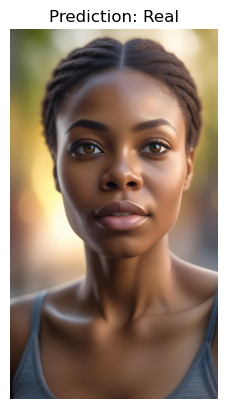

'Real'

In [60]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    prediction = model.predict(image)
    result = "Fake" if prediction[0][0] > 0.5 else "Real"
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis("off")
    plt.show()
    
    return result

# Test on an image
predict_image("D:\\Project 1\\ai-generated-8529984_1280.jpg")





In [3]:
import os

image_path = "dataset/fake/sample_fake.jpg"

if not os.path.exists(image_path):
    print(f"Error: File not found at {image_path}")
else:
    print("File found!")


Error: File not found at dataset/fake/sample_fake.jpg


In [13]:
import os

fake_images_folder = r"D:\Project 1\archive\Dataset\Test\Fake"  # Change this to your Fake dataset path
fake_images = [os.path.join(fake_images_folder, f) for f in os.listdir(fake_images_folder) if f.endswith(('.jpg', '.png'))]

for fake_image in fake_images[:50]:  # Test first 5 fake images
    result = predict_image(fake_image)
    print(f"{fake_image} → {result}")


NameError: name 'preprocess_image' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


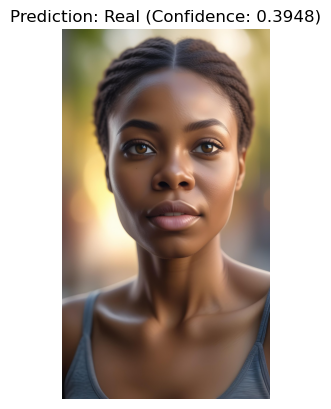

'Real'

In [80]:
def predict_image(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    prediction = model.predict(image)[0][0]
    confidence = float(prediction)

    result = "Fake" if confidence > 0.5 else "Real"
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(f"Prediction: {result} (Confidence: {confidence:.4f})")
    plt.axis("off")
    plt.show()
    
    return result

# Test on an image
predict_image("D:\\Project 1\\ai-generated-8529984_1280.jpg")


In [78]:
from torchvision import datasets, transforms
from collections import Counter

# Set dataset path
DATASET_PATH = "D:/Project 1/archive/Dataset/Train"

# Define image transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset using ImageFolder
train_data = datasets.ImageFolder(root=DATASET_PATH, transform=transform_train)

# Check dataset balance
labels = [label for _, label in train_data.samples]  # Get labels
counter = Counter(labels)

print(f"Real images: {counter[0]}")
print(f"Fake images: {counter[1]}")


Real images: 70001
Fake images: 70001


In [15]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

y_true, y_pred = [], []

for i in range(len(val_generator)):
    X, y = next(val_generator)  # ✅ Use `next()` properly
    preds = model.predict(X)
    
    y_pred.extend(preds.flatten())
    y_true.extend(y)

# Convert predicted probabilities to binary (0 or 1)
y_pred = np.array(y_pred) > 0.5

# Print classification report and accuracy
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


NameError: name 'val_generator' is not defined

In [1]:
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

# Load trained deepfake detection model
model = tf.keras.models.load_model("deepfake_detector.h5")

# Image preprocessing function
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Streamlit UI
st.title("Deepfake Image Detector")
st.write("Upload an image to check if it's **Real or Fake**.")

# Upload image
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess and predict
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)[0][0]

    # Display results
    if prediction > 0.5:
        st.error("⚠️ **Deepfake Detected!** (Fake Image)")
    else:
        st.success("✅ **This is a Real Image!**")

    st.write(f"Confidence Score: {prediction:.4f}")


2025-03-20 15:41:50.106 
  command:

    streamlit run C:\Users\yugth\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
